In [1]:
using DataFrames
using CSV
using Dates 
using PyPlot
using StatsBase

In [2]:
# Read CSV (Only tweets that include hashtags in file - no zeros in hashtag column)
@time df = DataFrame!(CSV.File("whole_April_no_zeros_restructured.csv",delim = ','));

 57.377630 seconds (121.65 M allocations: 6.370 GiB, 22.07% gc time)


# Timeseries

## Measure the timeseries of the total volume of hashtag usage on hourly or daily scale

In [3]:
function hourly_binning(df)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))

    total_tweets = []
    dates = []
    Month = first_month
    
    while Month <= last_month
        
        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        if isempty(months_indices) != true
            first_day = minimum(Dates.day.(df.Created_at[months_indices]))
            last_day = maximum(Dates.day.(df.Created_at[months_indices]))
            Day = first_day

            # Loop over all days and bin every 1h
            while Day <= last_day
                day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
                day_range = months_indices[day_range_]
                
                b = Month
                c = Day
                d = "$c.$b"
                push!(dates,d)
                
                if length(day_range) != 0

                    Day_start = day_range[1]
                    Day_end = day_range[end]

                    #hourly binning
                    for j in 0:23
                        bin = length(findall((i->i==j), Dates.hour.(df.Created_at[Day_start:Day_end])))
                        push!(total_tweets, bin)
                    end
                    
                else
                    for j in 0:23
                        push!(total_tweets, 0)
                    end
                end
                Day+=1
            end
            Month += 1 
        else
            Month += 1
        end
    end
    return total_tweets, dates
end

hourly_binning (generic function with 1 method)

In [4]:
tweet_series, dates = hourly_binning(df);

In [5]:
function daily_binning(df)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))

    total_tweets = []
    dates = []
    Month = first_month
    
    while Month <= last_month
        
        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        if isempty(months_indices) != true
            first_day = minimum(Dates.day.(df.Created_at[months_indices]))
            last_day = maximum(Dates.day.(df.Created_at[months_indices]))
            Day = first_day

            # Loop over all days and bin every 1h
            while Day <= last_day
                day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
                day_range = months_indices[day_range_]

                b = Month
                c = Day
                d = "$c.$b"
                push!(dates,d)
                
                if length(day_range) != 0
                    
                    bin = length(day_range)
                    push!(total_tweets, bin)
                else
                    push!(total_tweets, 0)
                end
                Day+=1
            end
            Month += 1 
        else
            Month += 1
        end
    end
    return total_tweets, dates
end

daily_binning (generic function with 1 method)

In [10]:
tweet_series, dates = daily_binning(df)

(Any[594626, 726105, 718286, 716386, 691118, 1352310, 2192259, 2293275, 2279763, 2122866  …  828341, 818197, 816754, 744809, 791010, 763301, 832960, 810113, 808474, 770894], Any["1.4", "2.4", "3.4", "4.4", "5.4", "6.4", "7.4", "8.4", "9.4", "10.4"  …  "21.4", "22.4", "23.4", "24.4", "25.4", "26.4", "27.4", "28.4", "29.4", "30.4"])

# Birth-death

## Measure how many tweets have been introduced to the system (births) and which have been removed (deaths) per time step

In [6]:
# This algorithm does actually not just save the births and the deaths but also the number of different hashtags 
# that appear more than 5 times and the dates on a daily scale

function BirthDeath_variable_binning(df,stepsize)
    # Find the range of the data (in case it is all the same month. If not - at first seperating the months.)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))

    deaths = []
    births = []

    diff_hashs = []
    
    dates = []

    Month = first_month

    last_uniques = []
    first_uniques = []

    while Month <= last_month

        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        if isempty(months_indices) != true
            first_day = minimum(Dates.day.(df.Created_at[months_indices]))
            last_day = maximum(Dates.day.(df.Created_at[months_indices]))
            println(first_day, " - ", last_day , " month: ", Month)
            Day = first_day            
            # Loop over all days and bin every hour
            while Day <= last_day 

                day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
                day_range = months_indices[day_range_]
                
                b = Month
                c = Day
                d = "$c.$b"
                push!(dates,d)
            
                if length(day_range) != 0

                    Day_start = day_range[1]
                    Day_end = day_range[end]
                    
                    first_hour = minimum(Dates.hour.(df.Created_at[Day_start:Day_end]))
                    last_hour = maximum(Dates.hour.(df.Created_at[Day_start:Day_end]))

                    for j in 0:stepsize:23
                        last_uniques = copy(first_uniques)
                        # find all Hashtags posted in given range (1h/2h/24h..)
                        hour_indices = findall((i->j<=i<=j+stepsize-1), Dates.hour.(df.Created_at[Day_start:Day_end]))
                        # create countmap
                        pop = countmap(df.Hashtags[hour_indices])
                        # filter all posts with occurrence higher than x 
                        filtered_pop = filter(tuple -> last(tuple) > 5, collect(pop))
                        # Create Array with all hashtags 
                        first_uniques = [filtered_pop[i][1] for i in 1:length(filtered_pop)]
                        # push the number of different hashtags
                        push!(diff_hashs,length(first_uniques)) #number off different hashtags
                        dead = 0
                        born = 0

                        # check the existence/non existence before/after
                        for j in last_uniques
                            if j ∉ first_uniques
                                dead +=1
                            end
                        end

                        for k in first_uniques
                            if k ∉ last_uniques
                                born += 1
                            end
                        end
                        push!(deaths,dead)
                        push!(births,born)
                    end
                else
                    first_uniques = []
                    for j in 0:stepsize:23
                        push!(diff_hashs,0)
                        push!(deaths,0)
                        push!(births,0)
                    end
                    #println("Day ",Day," of month ",Month," is done")
                end
                Day +=1
            end
            Month += 1
        else
            Month += 1
        end
    end

    return deaths, births, diff_hashs, dates
end

BirthDeath_variable_binning (generic function with 1 method)

In [11]:
stepsize = 24 # 24 hours ->(1 bin = 1 day)
deaths, births, diff_hashs, dates = BirthDeath_variable_binning(df,stepsize)

1 - 30 month: 4


(Any[0, 0, 80, 30, 298, 0, 0, 0, 153, 1579  …  0, 114, 26, 928, 0, 377, 0, 266, 13, 523], Any[8750, 1610, 0, 0, 0, 7857, 9414, 1037, 0, 0  …  67, 0, 0, 0, 602, 0, 892, 0, 0, 0], Any[8750, 10360, 10280, 10250, 9952, 17809, 27223, 28260, 28107, 26528  …  11647, 11533, 11507, 10579, 11181, 10804, 11696, 11430, 11417, 10894], Any["1.4", "2.4", "3.4", "4.4", "5.4", "6.4", "7.4", "8.4", "9.4", "10.4"  …  "21.4", "22.4", "23.4", "24.4", "25.4", "26.4", "27.4", "28.4", "29.4", "30.4"])

# Entropy

## It is kind of an entropy measurement which is taking into account how many different hashtags (in percentage) are used by 95% of the users. 
### This can be done by using the following algorithm: At first rank all hashtags in a given time window from the most popular to the least. Then calculate for the first hashtag in the list the set of unique users that used this hashtag. Repeat this for the second element in the list and join the two sets, whereas in this case set is meant in the mathematical sense: a list of unique objects with no repetition, therefore join means the union operation in set theory. Repeat this step until the set covers 95% of the total number of unique users.

In [ ]:
function Entropy(df, percentage,stepsize)
    
    percentage = percentage/100
    # Find the range of the data (in case it is all the same month. If not - at first seperating the months.)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))

    Month = first_month
    dates = []
    htag_percentage = []

    while Month <= last_month

        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        first_day = minimum(Dates.day.(df.Created_at[months_indices]))
        last_day = maximum(Dates.day.(df.Created_at[months_indices]))
        Day = first_day
        # Loop over all days and bin every hour
        while Day <= last_day
            #day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
            #day_range = months_indices[day_range_]
            
            b = Month
            c = Day
            d = "$c.$b"
            push!(dates,d)
            #println(Month, " ", Day)
            
            if length(day_range) != 0

                Day_start = day_range[1]
                Day_end = day_range[end]

                for j in 0:stepsize:23
                    #list for user that used a certain hashtag 
                    user_list = []
                    
                    # find all Hashtags posted in given range (1h/2h/24h..)
                    hour_indices = findall((i->j<=i<=j+stepsize-1), Dates.hour.(df.Created_at[Day_start:Day_end]))
                    
                    # create countmap of Hashtags
                    pop_hts = countmap(df.Hashtags[hour_indices])
                    #Parse to tuple Array
                    array_pop_hts = collect(pop_hts)
                    # sort by counts
                    sort!(array_pop_hts, by = tuple -> last(tuple), rev=true)
                    # Create Array with all countings of hashtags
                    hashtags = [array_pop_hts[i][1] for i in 1:length(array_pop_hts)]
                    total_diff_htgs = length(hashtags)
                    
                    # unique users 
                    unique_users = unique(df.USER[hour_indices])
                    total_user = length(unique_users)
                    user_perc = Int(floor(total_user*percentage))
                    
                    htg_number = 0
                    while length(user_list) < user_perc
                        htg_number += 1
                        htg_inds = findall(i->i==hashtags[htg_number], df.Hashtags[hour_indices])
                        htg_user = unique(df.USER[hour_indices][htg_inds])
                        user_list = union(user_list,htg_user)
                    end
                    if total_diff_htgs != 0 
                        push!(htag_percentage, htg_number/total_diff_htgs)
                    else
                        push!(htag_percentage, 0)
                    end
                    #println("done with the ", j,". hour")
                end
                println("done with the ", Day)
            end
            Day+=1
        end
        Month+=1
    end
    return htag_percentage, dates
end

In [ ]:
stepsize = 24
percentage = 95
@time htag_percentage, dates = Entropy(df, percentage,stepsize) 

In [12]:
# For the repository this measure was read in from a file with already taken measurements
# Read in textfile 
new_a = []
infile = "htag_percentage_April_daily.txt"
open(infile, "r") do f
  for ln in eachline(f)
    push!(new_a,ln)
  end
end
htag_perc = eval(Meta.parse.(new_a))
htag_perc.*=100
htag_perc = Int.(round.(htag_perc))
print(length(htag_perc))

30

# Mean persistence time

## It is representing the mean time a hashtag was "alive", more precise the time it was used.

In [13]:
function persistence_time(df,stepsize)
    # Find the range of the data (in case it is all the same month. If not - at first seperating the months.)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))

    deaths = []
    births = []

    diff_hashs = []
    
    dates = []
    
    hash_dict = Dict()
    persistence_times = []
    
    Month = first_month

    last_uniques = []
    first_uniques = []

    while Month <= last_month

        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        first_day = minimum(Dates.day.(df.Created_at[months_indices]))
        last_day = maximum(Dates.day.(df.Created_at[months_indices]))
        Day = first_day
        # Loop over all days and bin every 6h
        persistences = []
        while Day <= last_day
            day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
            day_range = months_indices[day_range_]
            
            b = Month
            c = Day
            d = "$c.$b"
            push!(dates,d)
            
            if length(day_range) != 0

                Day_start = day_range[1]
                Day_end = day_range[end]

                for j in 0:stepsize:23
                    last_uniques = copy(first_uniques)
                    # find all Hashtags posted in given range (1h/2h/24h..)
                    hour_indices = findall((i->j<=i<=j+stepsize-1), Dates.hour.(df.Created_at[Day_start:Day_end]))
                    # create countmap
                    pop = countmap(df.Hashtags[hour_indices])
                    # filter all posts with occurrence higher than x 
                    filtered_pop = filter(tuple -> last(tuple) > 5, collect(pop))
                    # Create Array with all hashtags 
                    first_uniques = [filtered_pop[i][1] for i in 1:length(filtered_pop)]
                    # push the number of different hashtags
                    push!(diff_hashs,length(first_uniques)) #number off different hashtags
                    dead = 0
                    born = 0


                    for h in last_uniques
                        if h ∉ first_uniques
                            dead +=1
                            persist = (Date(df.Created_at[Day_start]) - hash_dict[h]).value
                            delete!(hash_dict,h)
                            push!(persistences, persist)
                        end
                    end

                    for k in first_uniques
                        if k ∉ last_uniques
                            born += 1
                            hash_dict[k] = Date(df.Created_at[Day_start])
                        end
                    end
                    push!(deaths,dead)
                    push!(births,born)
                end
                #println("Day ",Day," of month ",Month," is done")
            end
            if length(persistences) != 0 
                ave_persist = round(mean(persistences),digits=3)
                push!(persistence_times,ave_persist)
            else
                push!(persistence_times,0)
            end            
            Day +=1            
        end
        Month += 1
    end

    return deaths, births, diff_hashs, dates,persistence_times
end

persistence_time (generic function with 1 method)

In [14]:
stepsize = 24 
deaths, births, diff_hashs, dates,persistence_times = persistence_time(df,stepsize)

(Any[0, 0, 80, 30, 298, 0, 0, 0, 153, 1579  …  0, 114, 26, 928, 0, 377, 0, 266, 13, 523], Any[8750, 1610, 0, 0, 0, 7857, 9414, 1037, 0, 0  …  67, 0, 0, 0, 602, 0, 892, 0, 0, 0], Any[8750, 10360, 10280, 10250, 9952, 17809, 27223, 28260, 28107, 26528  …  11647, 11533, 11507, 10579, 11181, 10804, 11696, 11430, 11417, 10894], Any["1.4", "2.4", "3.4", "4.4", "5.4", "6.4", "7.4", "8.4", "9.4", "10.4"  …  "21.4", "22.4", "23.4", "24.4", "25.4", "26.4", "27.4", "28.4", "29.4", "30.4"], Any[0, 0, 1.0, 1.273, 2.534, 2.534, 2.534, 2.534, 2.116, 2.355  …  5.222, 5.202, 5.199, 5.149, 5.149, 5.079, 5.079, 5.032, 5.03, 4.984])

# Most popular

## The timeseries of the volume of the 100 most popular hashtags

In [15]:
function most_popular(df,rank)
    # Find the range of the data (in case it is all the same month. If not - at first seperating the months.)
    first_month = minimum(Dates.month.(df.Created_at))
    last_month = maximum(Dates.month.(df.Created_at))
    Month = first_month
    # one entry is one distribution
    most_pop = []
    dates = []

    while Month <= last_month

        months_indices = findall(i->i==Month, Dates.month.(df.Created_at))
        first_day = minimum(Dates.day.(df.Created_at[months_indices]))
        last_day = maximum(Dates.day.(df.Created_at[months_indices]))
        Day = first_day
        # Loop over all days and bin every hour
        while Day <= last_day
            
            b = Month
            c = Day
            d = "$c.$b"
            push!(dates,d)
            
            day_range_ = findall((i->i==Day), Dates.day.(df.Created_at[months_indices]))
            day_range = months_indices[day_range_]

            if length(day_range) != 0

                temp = df.Hashtags[day_range]

                # create countmap of Hashtags
                pop_hts = countmap(temp)
                #Parse to tuple Array
                array_pop_hts = collect(pop_hts)
                # sort by counts
                sort!(array_pop_hts, by = tuple -> last(tuple), rev=true)
                # count the popularity of the first 100 most popular 
                count = 0
                if length(array_pop_hts) > rank
                    for i in 1:rank
                        count += array_pop_hts[i][2]
                    end
                else
                    for i in 1:length(array_pop_hts)  
                        count += array_pop_hts[i][2]
                    end
                end
                push!(most_pop, count)
            else
                push!(most_pop, 0)
            end
            Day+=1
        end
        Month +=1
    end
    return most_pop, dates
end

most_popular (generic function with 1 method)

In [16]:
rank = 100
@time most_pop, dates = most_popular(df,rank)

121.458663 seconds (6.66 M allocations: 16.870 GiB, 20.77% gc time)


(Any[263170, 317133, 309281, 314837, 298937, 568486, 944097, 959634, 941292, 891831  …  341001, 324089, 326953, 289385, 304730, 304262, 337972, 325963, 311371, 279955], Any["1.4", "2.4", "3.4", "4.4", "5.4", "6.4", "7.4", "8.4", "9.4", "10.4"  …  "21.4", "22.4", "23.4", "24.4", "25.4", "26.4", "27.4", "28.4", "29.4", "30.4"])

# Plotting

## Timeseries and microscopic measures on hourly scale

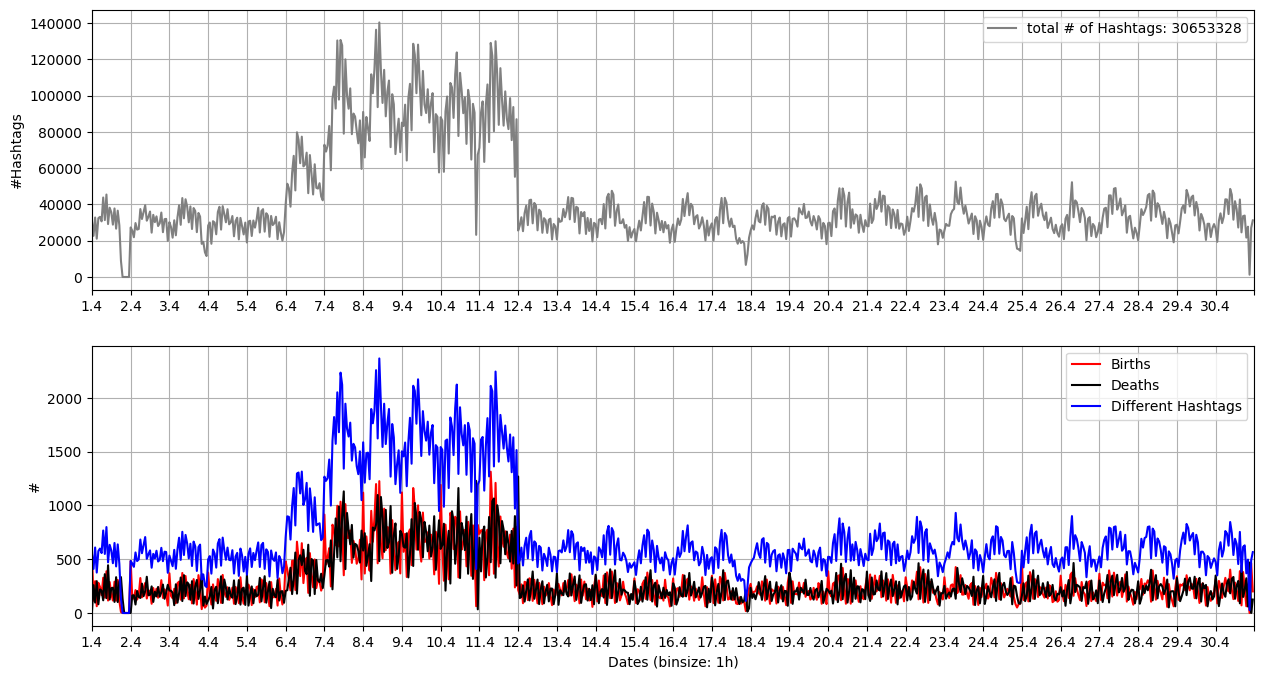

PyObject <matplotlib.legend.Legend object at 0x7f94e8dc6050>

In [8]:
figure(figsize=(15,8))
subplot(211)
points = Int(length(tweet_series))
stepsize = 24 #  24h/binsize*distance of ticks [days] --> (24/1)*1=24
total = sum(tweet_series) 
plot(tweet_series,color="grey",label="total # of Hashtags: $total")

xticks(0:stepsize:points,dates)
xlim(0,points)
ylabel("#Hashtags")
legend()
grid("on")

subplot(212)
points = Int(length(deaths))
stepsize = 24 
plot(births,label="Births",color="red") 
plot(deaths,label="Deaths",color="black")
plot(diff_hashs,label="Different Hashtags",color="blue")
xticks(0:stepsize:points,dates)
xlim(0,points)
ylabel("#")
xlabel("Dates (binsize: 1h)")
grid("on")
legend()

## Plotting various measures on daily scale

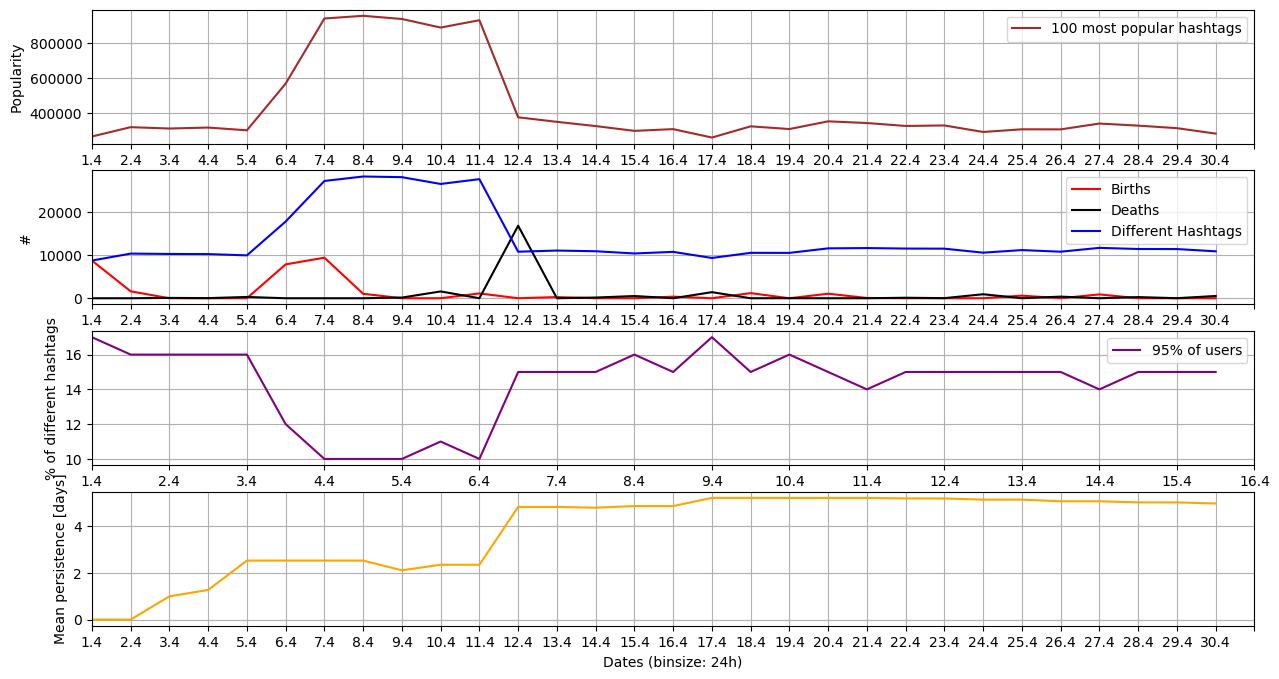

In [20]:
figure(figsize=(15,8))
#fig.subplots_adjust(hspace=0.25, wspace=0.25)
subplot(411)
points = Int(length(most_pop))
stepsize = 1 # 24h/binsize*distance of ticks --> 24/24=1
plot(most_pop,label="$rank most popular hashtags",color="brown") 
xticks(0:stepsize:points,dates) # 2nd set
xlim(0,points)
ylabel("Popularity")
grid("on")
legend()

subplot(412)
points = Int(length(deaths))
stepsize = 1
plot(births,label="Births",color="red") 
plot(deaths,label="Deaths",color="black")
plot(diff_hashs,label="Different Hashtags",color="blue")
xticks(0:stepsize:points,dates)
xlim(0,points)
ylabel("#")
grid("on")
legend()

subplot(413)
points = Int(length(htag_perc))
stepsize = 2 
plot(htag_perc,label="95% of users",color="purple") 
xticks(0:stepsize:points,dates) 
xlim(0,points)
ylabel("% of different hashtags")
xlabel("Dates (binsize: 24h)")
grid("on")
legend()

subplot(414)
points = Int(length(persistence_times))
stepsize = 1
plot(persistence_times,color="orange") 
xticks(0:stepsize:points,dates)
xlim(0,points)
ylabel("Mean persistence [days]")
xlabel("Dates (binsize: 24h)")
grid("on")

## Hashtag series plotted with most popular 

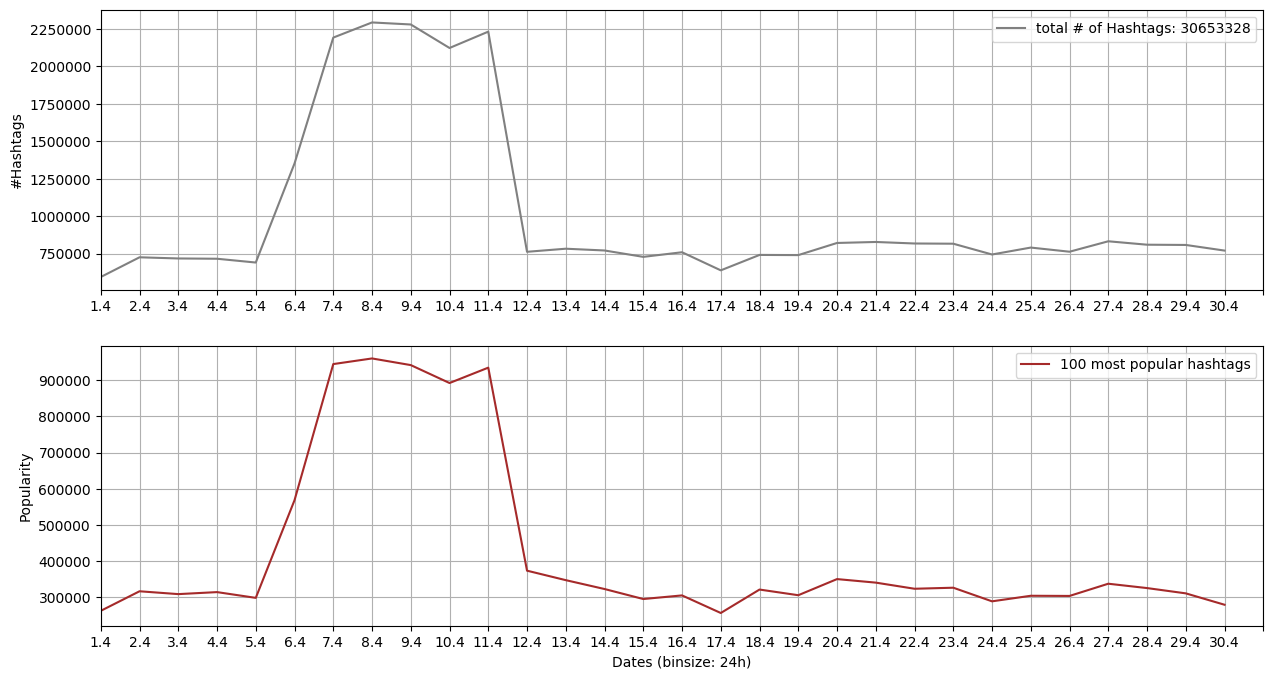

PyObject <matplotlib.legend.Legend object at 0x7f94e8766290>

In [19]:
figure(figsize=(15,8))
subplot(211)
points = Int(length(tweet_series))
stepsize = 1 
total = sum(tweet_series) 
plot(tweet_series,color="grey",label="total # of Hashtags: $total")
xticks(0:stepsize:points,dates)
xlim(0,points)
ylabel("#Hashtags")
legend()
grid("on")

subplot(212)
points = Int(length(most_pop))
stepsize = 1 
plot(most_pop,label="$rank most popular hashtags",color="brown") 
xticks(0:stepsize:points,dates) 
xlim(0,points)
ylabel("Popularity")
xlabel("Dates (binsize: 24h)")
grid("on")
legend()